# 1. The XArray THREDDS Problem Description
This notebook contains a description of a common error find while using the [_.load()_](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.load.html) function in [_xarray_](https://docs.xarray.dev/en/latest/index.html) package while connected in a THREDDS server to load data locally.

In this example, outputs from a global ocean model ([HYCOM](https://www.hycom.org/)) are acessed through a THREDDS server. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray
import requests
from bs4 import BeautifulSoup
from collections import Counter
import re
import load_by_step

In [2]:
def convert_to_360(lon):
    return float(np.remainder(lon + 360, 360))

In [3]:
###File Location and Domain Definition
url = "https://tds.hycom.org/thredds/dodsC/GLBy0.08/expt_93.0"
ds = xr.open_dataset(url, drop_variables="tau")

### Domain Specification
lonmin=-54
lonmax=-31
latmin=-36
latmax=7
selvar = 'water_u'

da = ds[selvar].sel(lon=slice(convert_to_360(lonmin), convert_to_360(lonmax)), lat=slice(latmin,latmax))

In [4]:
unit = 1e9
print(f'The present dataset is about {np.round(da.nbytes/unit)}GB in size')
print(f'The amount of data present in a single level is about {np.round(da.sel(depth=0).nbytes/unit)}GB')

The present dataset is about 831.0GB in size
The amount of data present in a single level is about 21.0GB


In [6]:
test1 = da.sel(depth=0).load()

oc_open: server error retrieving url: code=? message="Error {
    code = 500;
    message = "opendap.dap.DataReadException: Inconsistent array length read: 1165128303 != 1914731274; water_u -- 0:16752,0:0,1100:2175,3825:4112";
}"oc_open: server error retrieving url: code=? message="Error {
    code = 500;
    message = "opendap.dap.DataReadException: Inconsistent array length read: 1165128303 != 1914731274; water_u -- 0:16752,0:0,1100:2175,3825:4112";
}"

KeyboardInterrupt: 

The runtime error may arises from the fact that a huge amount of data is trying to be loaded but the server does not respond quickly. So we could try to select less data an try to load it again and see what happens:

In [5]:
test2 = da.sel(time=slice("2024-01-01", "2024-01-10"))
print(f'The present dataset is about {np.round(test2.nbytes/unit)}GB in size')

The present dataset is about 4.0GB in size


In [11]:
test2 = da.sel(time=slice("2024-01-01", "2024-01-10")).load()

oc_open: server error retrieving url: code=? message="Error {
    code = 500;
    message = "java.net.SocketTimeoutException: Read timed out; water_u -- 14821:14900,0:39,1100:2175,3825:4112";
}"oc_open: server error retrieving url: code=? message="Error {
    code = 500;
    message = "java.net.SocketTimeoutException: Read timed out; water_u -- 14821:14900,0:39,1100:2175,3825:4112";
}"

KeyboardInterrupt: 

So as we can see, even selecting a slice of data with reduced size, the runtime error continued. 
Now let's check if people are talking about this kind of problem in the HYCOM forum

In [6]:
try:
    from wordcloud import WordCloud
    from nltk.corpus import stopwords
    from nltk import pos_tag  # Import pos_tag for POS tagging
    from nltk.tokenize import word_tokenize 
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('averaged_perceptron_tagger_eng')

except:
    %pip install wordcloud
    %pip install nltk
    %pip install selenium
    from wordcloud import WordCloud
    from nltk.corpus import stopwords
    from nltk import pos_tag  # Import pos_tag for POS tagging
    from nltk.tokenize import word_tokenize 
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('averaged_perceptron_tagger_eng') 

  Using cached wordcloud-1.9.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (541 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached regex-2024.7.24-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.7.24-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (790 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached selenium-4.24.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached trio-0.26.2-py3-none-any.whl.metadata (8.6 kB)
  Using cached trio_websocket-0.11.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached outcome-1.3.0.post0-py2.py3-none-any.whl.metadata (2.6 kB)
  Using cached wsproto-1.2.0-py3-none-any.whl.metadata (5.6 kB)
Using cach

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [7]:
def get_words_from_topic(url):
    # Faz a requisição para acessar a página
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erro ao acessar a página {url}")
        return []

    # Extrai o conteúdo da página
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Encontra todo o texto nos tópicos (ajustar seletor conforme necessário)
    text_content = soup.get_text()
    
    # Remove pontuação e números, e converte para minúsculas
    words = re.findall(r'\b[a-zá-úà-ùãõâêîôûç]+\b', text_content.lower())
    
    return words

def filter_words(words):
    # Get the list of English stopwords and extend with common articles/prepositions
    stop_words = set(stopwords.words('english'))

    # POS tagging
    words_with_pos = pos_tag(words)

    # Filter out stopwords and nouns
    filtered_words = [
        word for word, pos in words_with_pos
        if word not in stop_words and pos not in ['NN', 'NNS', 'NNP', 'NNPS']
    ]
    
    return filtered_words

def main_url_search(urls):
    # Lista de URLs dos tópicos do fórum (adicione mais URLs conforme necessário)
    all_words = []
    # Para cada URL de tópico, extrai as palavras
    for url in urls:
        words = get_words_from_topic(url)
        filtered_words = filter_words(words)
        all_words.extend(filtered_words)
    
    # Contagem das palavras
    word_count = Counter(all_words)

    return word_count

url = 'https://groups.google.com/a/hycom.org/g/forum'
response = requests.get(url)
# Extrai o conteúdo da página
soup = BeautifulSoup(response.text, 'html.parser')

In [8]:
# Define the list of words to color differently
highlight_words = {"unread":"red","runtime":"red","via":"red","opendap":"red","https":"red","read":"red","netcdf":"red","download":"red", "downloading": "red", "thredds": "red","accessing":"red","access":"red"}

# Custom color function
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return highlight_words.get(word, "lightgray")

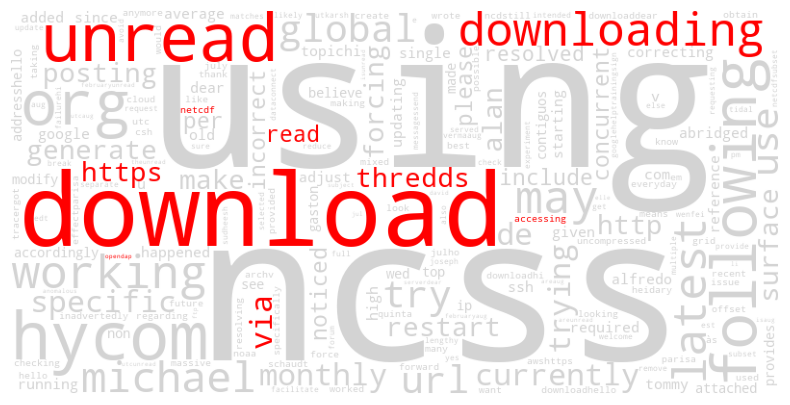

In [10]:
word_counters = main_url_search([url])
wordcloud = WordCloud(width=800, height=400, background_color='white',color_func=color_func).generate_from_frequencies(word_counters)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)#, interpolation='bilinear')
plt.axis('off')
plt.show()

It seems that the runtime errors are very common while trying to load a dataset as we can see by the above example and also by the print screen below, where the red poligons highlight the errors related with donwloading data in the HYCOM forum

![Minha Imagem](hycom_forum.png)

# 2. Using the xarray accessor _load_by_steps_ to access HYCOM data
## **2.1 Example 1**: **_load_by_step_()** by splitting Spatio-Temporal maps in time

In [11]:
da2 = da.sel(depth=0,time=slice("2024-01-01", "2024-01-10"))
da2._in_memory

False

In [12]:
da3 = da2.lbs.load_by_step(time=100)

Loading '49.6MB' of 'water_u' between time=[2024-01-01T00:00:00.000000000, 2024-01-10T21:00:00.000000000]: 100%|██████████| 1/1 [00:26<00:00, 26.80s/it]


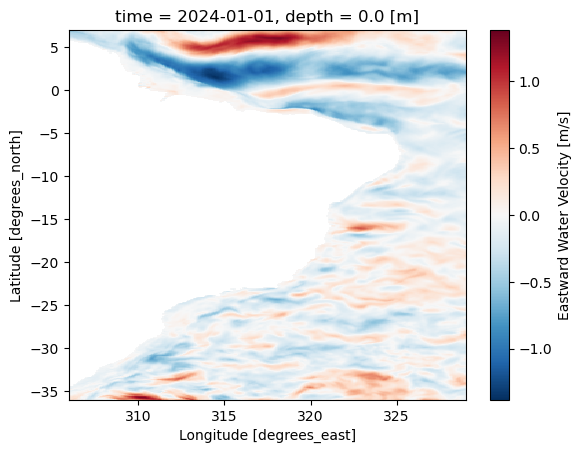

In [13]:
da3[0].plot()

In [14]:
number_of_points = [10,100,250,500,1000]

In [16]:
import time

req_time_load = []

for i in range(len(number_of_points)):
    ds_load = da.sel(depth=0).isel(time=np.arange(0,number_of_points[i]))

    try:
        st_time_load = time.time()
        ds2_load = ds_load.load()
        ex_time_load = time.time()
        req_time_load.append(ex_time_load-st_time_load)
    except:
        print(f"Not able to compute {number_of_points[i]} days, an error occurred")
        req_time_load.append(np.nan)

    del ds_load,ds2_load

In [18]:
req_time_lbs = []

for i in range(len(number_of_points)):
    ds_lbs = da.sel(depth=0).isel(time=np.arange(0,number_of_points[i]))
    if number_of_points[i]<=10:
        stps = int(number_of_points[i])
    else:
        stps = int(number_of_points[i]/10)
        
    st_time_lbs = time.time()
    ds2_lbs = ds_lbs.lbs.load_by_step(time=stps)
    ex_time_lbs = time.time()

    req_time_lbs.append(ex_time_lbs-st_time_lbs)

    del ds_lbs,ds2_lbs

Loading '6.2MB' of 'water_u' between time=[2018-12-04T12:00:00.000000000, 2018-12-05T15:00:00.000000000]: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
Loading '6.2MB' of 'water_u' between time=[2018-12-15T18:00:00.000000000, 2018-12-16T21:00:00.000000000]: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]
Loading '15.5MB' of 'water_u' between time=[2019-01-01T15:00:00.000000000, 2019-01-04T15:00:00.000000000]: 100%|██████████| 10/10 [00:55<00:00,  5.58s/it]
Loading '31.0MB' of 'water_u' between time=[2019-01-29T21:00:00.000000000, 2019-02-05T00:00:00.000000000]: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]
Loading '62.0MB' of 'water_u' between time=[2019-03-27T03:00:00.000000000, 2019-04-08T12:00:00.000000000]: 100%|██████████| 10/10 [02:05<00:00, 12.53s/it]


![comparison 1](intercomparison3.png)

## **2.2 Example 2**: **_load_by_step_()** by splitting Spatio-Temporal maps in latitude x longitude mini-maps

Another option is to split an spatio-temporal dataset into subdomais with pre-specified sizes in latitude x longitude dimensions, load each of then iteratively, and retrieve the whole dataset at the end of the operation.

In [22]:
def get_steps(dim_size):
    order10 = np.floor(np.log10(dim_size))
    steps = 10**(order10-1)                  
    return int(steps)
    
latsteps = get_steps(da.lat.size) 
lonsteps = get_steps(da.lon.size)

In [23]:
da4 = da2.lbs.load_by_step(lat=latsteps,lon=lonsteps)

Loading '97.3KB' of 'water_u' between lat=[4.0, 7.0], lon=[328.4000244140625, 328.9599609375]: 100%|██████████| 319/319 [04:13<00:00,  1.26it/s]                      


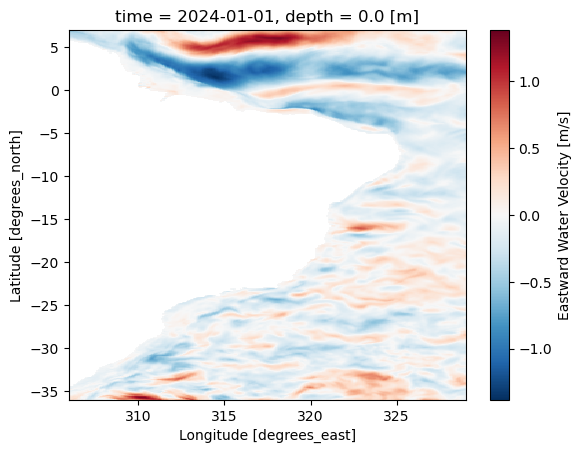

In [24]:
da4[0].plot()

In [25]:
req_time_lbs_ll = []

for i in range(len(number_of_points)):
    ds_lbs = da.sel(depth=0).isel(time=np.arange(0,number_of_points[i]))

    st_time_lbs_ll = time.time()
    ds2_lbs = ds_lbs.lbs.load_by_step(lat=latsteps)
    ex_time_lbs_ll = time.time()

    req_time_lbs_ll.append(ex_time_lbs_ll-st_time_lbs_ll)

    del ds_lbs,ds2_lbs

Loading '437.8KB' of 'water_u' between lat=[4.0, 7.0]: 100%|██████████| 11/11 [00:01<00:00,  7.60it/s]                 
Loading '4.4MB' of 'water_u' between lat=[4.0, 7.0]: 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]                 
Loading '10.9MB' of 'water_u' between lat=[4.0, 7.0]: 100%|██████████| 11/11 [00:40<00:00,  3.72s/it]                 
Loading '21.9MB' of 'water_u' between lat=[4.0, 7.0]: 100%|██████████| 11/11 [02:10<00:00, 11.84s/it]                 
Loading '43.8MB' of 'water_u' between lat=[4.0, 7.0]: 100%|██████████| 11/11 [05:47<00:00, 31.55s/it]                 


![comparisonwlat](intercomparison_wlat.png)

**Note:** It is important to say that sometimes subsetting too much the dataset into smallers chunks can compromise the speed of the job, since there will be a lot of threads delivered. The number of steps to be used are defined by the user but it is important to keep a balance between the number of requests and the size of the data.

## 3. Using the XArray _load_by_step()_ in different datasets
Now we use the **_load_by_step()_** function to access different datasets that are available in a THREEDS server. 

## 3.1 NCEP GFS Dataset

The [NCEP operational Global Forecast System](https://rda.ucar.edu/datasets/d084001/) analysis and forecast grids are on a 0.25 by 0.25 global latitude longitude grid. Here we use the **_load_by_step()_** accessor to retrieve this dataset.


In [26]:
gfs = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/files/g/d084001/2015/20150115/gfs.0p25.2015011500.f000.grib2')

In [27]:
gfs_r  = gfs['Temperature_surface']
gfs_l = gfs_r[0].load()

In [28]:
gfs_lb = gfs_r.lbs.load_by_step(lat=5)

Loading '5.8KB' of 'Temperature_surface' between lat=[-90.0, -90.0]: 100%|██████████| 145/145 [00:00<00:00, 285.68it/s]   


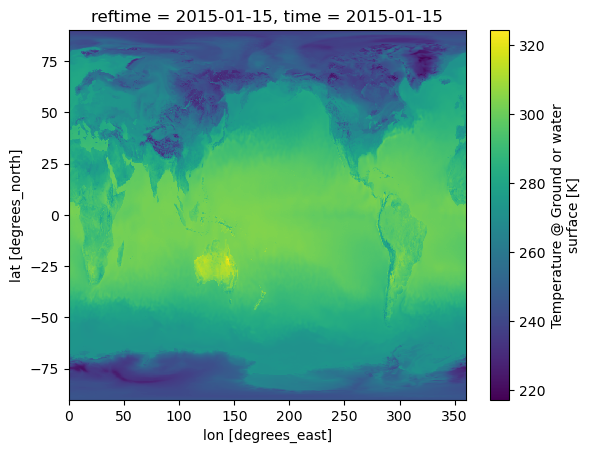

In [29]:
gfs_lb[0].plot()

## 3.2 NCEP-NCAR Reanalysis 1 

The [NCEP/NCAR Reanalysis 1](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html) consists of 4x daily, daily and monthly atmospheric model output from 1948 to near present in a 2.5° horizontal resolution grid. If the _xarray_ **_load()_** request gets higher than 500MB, a syntax error message is displayed (as below). However, using the **_load_by_step()_** function allows to successfully load the data. 

In [30]:
ncardata = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/pressure/air.4Xday.1981-2010.ltm.nc',decode_times=False)

/home/.pixi/envs/default/lib/python3.12/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [31]:
try:
    ncardata['air'].load()
except:
    print("ERROR")

syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: Request^ Too Large: 1043.63136 Mbytes, max=500.0
syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: Request^ Too Large: 1043.63136 Mbytes, max=500.0
syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: Request^ Too Large: 1043.63136 Mbytes, max=500.0


ERROR


In [32]:
testncar = ncardata['air'].lbs.load_by_step(time=10)

Loading '7.1MB' of 'air' between time=[-15761052.0, -15760998.0]: 100%|██████████| 146/146 [03:12<00:00,  1.32s/it]


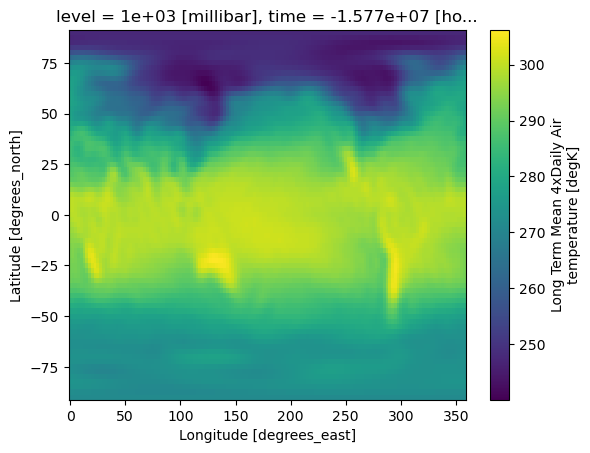

In [33]:
testncar[0][0].plot()

## 3.3 NCEI Gulf of Maine Operational Forecast System - GOMOFS

In [34]:
gomofs = xr.open_dataset('https://www.ncei.noaa.gov/thredds/dodsC/model-gomofs-agg/Aggregated_GOMOFS_Fields_Forecast_best.ncd')
gomofs

/home/.pixi/envs/default/lib/python3.12/site-packages/xarray/conventions.py:440: SerializationWarning: variable 'u' has multiple fill values {0.0, 1e+37}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/.pixi/envs/default/lib/python3.12/site-packages/xarray/conventions.py:440: SerializationWarning: variable 'v' has multiple fill values {0.0, 1e+37}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/.pixi/envs/default/lib/python3.12/site-packages/xarray/conventions.py:440: SerializationWarning: variable 'w' has multiple fill values {0.0, 1e+37}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/.pixi/envs/default/lib/python3.12/site-packages/xarray/conventions.py:440: SerializationWarning: variable 'temp' has multiple fill values {0.0, 1e+37}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/.pixi/envs/default/lib/python3.12/site-packages/xarray/conventions.py:440: SerializationWarning: variable 'salt' ha

<xarray.Dataset> Size: 10TB
Dimensions:          (s_rho: 30, s_w: 31, eta_rho: 777, xi_rho: 1173,
                      eta_u: 777, xi_u: 1172, eta_v: 776, xi_v: 1173,
                      eta_psi: 776, xi_psi: 1172, ocean_time: 1, time: 16434,
                      tracer: 2, boundary: 4)
Coordinates: (12/13)
  * s_rho            (s_rho) float64 240B -0.9833 -0.95 ... -0.05 -0.01667
  * s_w              (s_w) float64 248B -1.0 -0.9667 -0.9333 ... -0.03333 0.0
    lon_rho          (eta_rho, xi_rho) float64 7MB ...
    lat_rho          (eta_rho, xi_rho) float64 7MB ...
    lon_u            (eta_u, xi_u) float64 7MB ...
    lat_u            (eta_u, xi_u) float64 7MB ...
    ...               ...
    lat_v            (eta_v, xi_v) float64 7MB ...
    lon_psi          (eta_psi, xi_psi) float64 7MB ...
    lat_psi          (eta_psi, xi_psi) float64 7MB ...
  * ocean_time       (ocean_time) datetime64[ns] 8B 2024-08-23T15:00:00
  * time             (time) datetime64[ns] 131kB 2018-12-31T21:00:00 ... 2024...
    time_run         (time) datetime64[ns] 131kB ...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v,
                                eta_psi, xi_psi, tracer, boundary
Data variables: (12/99)
    ntimes           int32 4B ...
    ndtfast          int32 4B ...
    dt               float64 8B ...
    dtfast           float64 8B ...
    dstart           datetime64[ns] 8B ...
    nHIS             int32 4B ...
    ...               ...
    temp             (time, s_rho, eta_rho, xi_rho) float32 2TB ...
    salt             (time, s_rho, eta_rho, xi_rho) float32 2TB ...
    Pair             (time, eta_rho, xi_rho) float32 60GB ...
    Uwind            (time, eta_rho, xi_rho) float32 60GB ...
    Vwind            (time, eta_rho, xi_rho) float32 60GB ...
    time_offset      (time) datetime64[ns] 131kB ...
Attributes: (12/42)
    file:                            nos.gomofs.fields.nowcast.20240823.t18z_...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4
    type:                            ROMS/TOMS history file
    title:                           GOMOFS - Gulf of Maine Operational Forec...
    var_info:                        varinfo.yaml
    ...                              ...
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:                   GRID
    featureType:                     GRID
    location:                        Proto fmrc:Aggregated_GOMOFS_Fields_Fore...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               30

In [37]:
gmvar = gomofs['salt'].sel(time=slice('2024-01-01','2024-01-01'))
print(gmvar.nbytes/unit)

0.87496416


In [38]:
gmvar_l = gmvar.load()

oc_open: server error retrieving url: code=403 message="Request too big=874.96416 Mbytes, max=500.0"oc_open: server error retrieving url: code=403 message="Request too big=874.96416 Mbytes, max=500.0"

KeyboardInterrupt: 

In [39]:
gmvar_lbs = gmvar.lbs.load_by_step(time=4,s_rho=2)

Loading '29.2MB' of 'salt' between time=[2024-01-01T12:00:00.000000000, 2024-01-01T21:00:00.000000000], s_rho=[-0.05, -0.016666666666666666]: 100%|██████████| 30/30 [02:36<00:00,  5.22s/it]              


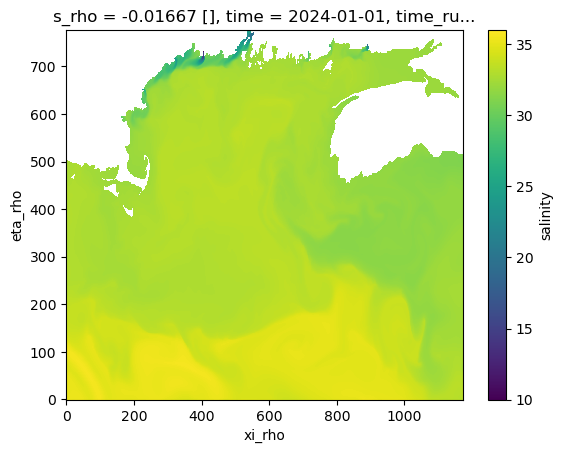

In [44]:
gmvar_lbs[0][-1].plot(vmin=10,vmax=36)

## 3.4 Altimeter SSH from a local file
The **_load_by_step()_** _accessor_ can also be used to split a huge amount of local data while loading it to the memory, as we can see in the example below, using grided maps of SSH delivered from altimetry by AVISO.

In [45]:
ssh_alt = xr.open_dataset('/home/jovyan/ohw24_proj_xarray_load_by_step_us/data/adt93-19.nc')
ssh_alt

<xarray.Dataset> Size: 859MB
Dimensions:    (time: 9928, latitude: 53, longitude: 204)
Coordinates:
  * time       (time) datetime64[ns] 79kB 1993-01-01 1993-01-02 ... 2020-03-07
  * latitude   (latitude) float32 212B -32.88 -32.62 -32.38 ... -20.12 -19.88
  * longitude  (longitude) float32 816B 309.1 309.4 309.6 ... 359.4 359.6 359.9
Data variables:
    adt        (time, latitude, longitude) float64 859MB ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    time_coverage_duration:          P1D
    time_coverage_end:               2020-03-07T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2020-03-07T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...
    History:                         Translated to CF-1.0 Conventions by Netc...

In [46]:
st_time_load = time.time()
ssh_load = ssh_alt['adt'].load()
end_time_load = time.time()
del ssh_load

In [47]:
st_time_load_lbs = time.time()
ssh_loadbs = ssh_alt['adt'].lbs.load_by_step(time=3)
end_time_load_lbs = time.time()
del ssh_loadbs